### A quick tutorial example for finding nearest-neighbors using sklearn


In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
#from sklearn.neighbors import NearestNeighbors
import sklearn
import sklearn.neighbors
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import ANSStools as atp
#from yodiipy import ANSStools as atp
#
import random
import geopy




### Really straight forward:
- Create two data sets:
  - A "Background" data set, XY_bg
  - A "Foreground" data set, XY_fg
  - Define the number of NN, n_NN
- Find the n_NN nearest neighbors of each XY_fg point in the background set XY_bg.
- Note the sklearn.NearestNeighbors.kneighbors() function return the indices of the XY_bg elements
- Then, plot the elements:
  - Each _fg and _bg element and the edges between the NN sets.


(0.0, 1.0)

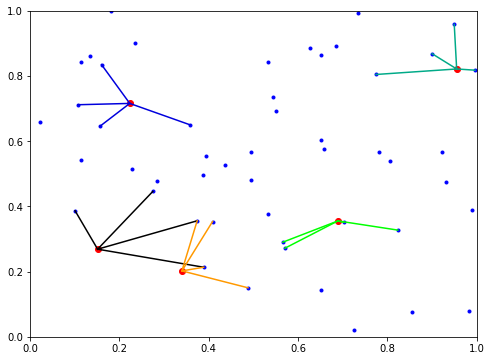

In [3]:
n1=50
n2 = 5
n_NN=4
#
XY_bg = numpy.array([numpy.random.uniform(size=n1), numpy.random.uniform(size=n1)]).T
XY_fg = numpy.array([numpy.random.uniform(size=n2), numpy.random.uniform(size=n2)]).T
#
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=n_NN, algorithm='ball_tree').fit(XY_bg)
#
distances, indices = nbrs.kneighbors(XY_fg)
#
plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(*XY_bg.T, marker='.', ls='', color='b', zorder=1)
ax.plot(*XY_fg.T, marker='o', ls='', color = 'r', zorder=2)
#
# make a color index:
color_idx = numpy.linspace(0, 1, len(XY_fg)+1)
cmap = plt.cm.spectral
#
for k, (ixs, dists, (x_fg, y_fg)) in enumerate(zip(indices, distances, XY_fg)):
    #
    clr = cmap(color_idx[k])
    #
    for (x_bg, y_bg),r in zip(XY_bg[ixs], dists):
        ax.plot([x_fg, x_bg], [y_fg, y_bg], ls='-', color=clr)
#
ax.set_ylim(0.,1.)
ax.set_xlim(0.,1.)



#### Interpolating or snapping to a discrete distribution
- We can also use NN to find NN elements in a 1D array
- We can use numpy.searchsorted():
  - https://docs.scipy.org/doc/numpy/reference/generated/numpy.searchsorted.html
- The basic idea is to find the new value's position in a sequence and then infer its estimated value somehow (probably by a weighted average).

js:  [[420 419 421 418]
 [619 620 618 621]
 [300 299 301 298]]
dists:  [[ 0.0021021   0.0029029   0.00710711  0.00790791]
 [ 0.0019019   0.0031031   0.00690691  0.00810811]
 [ 0.0015015   0.0035035   0.00650651  0.00850851]]
vals/rs: [ 2.1021021   2.0970971   2.10710711  2.09209209]/[ 0.0021021   0.0029029   0.00710711  0.00790791]/[ 0.87780072  0.87718758  0.8784108   0.87657136]
Y_estimate: 0.8775424441303804
average: 0.8775424441303804
****
vals/rs: [ 3.0980981   3.1031031   3.09309309  3.10810811]/[ 0.0019019   0.0031031   0.00690691  0.00810811]/[ 0.95486504  0.95509037  0.95463857  0.95531458]
Y_estimate: 0.9549503937551209
average: 0.9549503937551209
****
vals/rs: [ 1.5015015   1.4964965   1.50650651  1.49149149]/[ 0.0015015   0.0035035   0.00650651  0.00850851]/[ 0.77720462  0.77608673  0.77831692  0.77496324]
Y_estimate: 0.7768680118273242
average: 0.7768680118273242
****


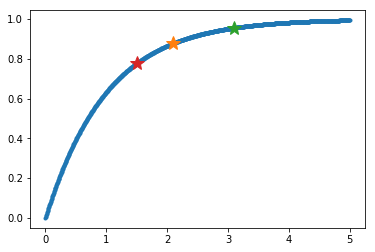

In [22]:
# using sklearn NN tools:
#
X = numpy.linspace(0., 5., 1000)
X_fg = [[2.1], [3.1], [1.5]]
Y = 1.-numpy.exp(-X)
#
plt.figure()
ax = plt.gca()
ax.plot(X,Y, '.-')
#

nbrs_1d = sklearn.neighbors.NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(numpy.atleast_2d(X).T)
dists, Js = nbrs_1d.kneighbors(X_fg)
print('js: ', Js)
print('dists: ', dists)

for rs, js, x in zip(dists, Js, X_fg):
    #
    # and a couple of ways to compute a wieghted average:
    print('vals/rs: {}/{}/{}'.format(X[js], rs, Y[js] ))
    print('Y_estimate: {}'.format(numpy.dot(Y[js], 1./rs)/numpy.sum(1./rs)))
    y_mean = numpy.average(Y[js], weights=1./rs)
    print('average: {}'.format(y_mean))
    #
    ax.plot(x, y_mean, marker='*', ms=15, ls='')
    print('****')

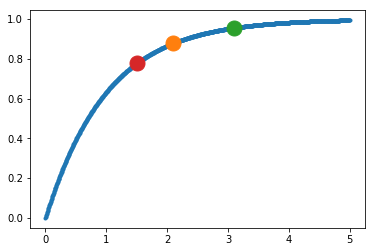

In [29]:
# We can also use numpy.searchsorted()
# We have to be careful to handle end-points, but the main points are the same.
# note: some of this code will probably be de-optimized, but it should be sufficient to illustrate the 
#    points of interest
#
class XY_data(list):
    def __init__(self, XY, n_NN=2):
        self.n_NN=n_NN
        #
        super(XY_data, self).__init__(sorted(XY, key = lambda rw:rw[0]))
    #
    @property
    def X(self):
        return numpy.array(self).T[0]
    #
    @property
    def Y(self):
        return numpy.array(self).T[1]
    #
    def get_y(self, x, n_NN=None):
        n_NN = n_NN or self.n_NN
        n_NN = n_NN or 2
        #
        # note: "x" can, for .searchsorted(), be array-like. here, i think we'll only handle the scalar case.
        k = numpy.searchsorted(self.X, x)
        ks = numpy.array([max(0, k-1), k])
        ws = [1./r if r!=0 else 1. for r in [x-self.X[k] for k in ks]]
        #
        return numpy.average(numpy.array(self.Y)[ks], weights=ws)

#
my_XY = XY_data(numpy.array([X,Y]).T)
X_fg = [[2.1], [3.1], [1.5]]

plt.figure()
ax = plt.gca()
ax.plot(X,Y, '.-')
#
for x in X_fg:
    y = my_XY.get_y(x)
    #
    ax.plot([x], [y], marker='o', ms=15, zorder=11)